## 프로젝트: 한영 번역기 만들기

### Step 1. 데이터 다운로드

In [1]:
#!gzip -d korean-english-park.train.tar.gz
!tar -xvf korean-english-park.train.tar

korean-english-park.train.en
korean-english-park.train.ko


In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import re
import time
import re
import os
import io
from konlpy.tag import Mecab
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

print("완료!")

완료!


### Step 2. 데이터 정제 및 토큰화
 - 데이터로드

In [3]:
en_path_to_file = "/aiffel/aiffel/project/seq2seq/korean-english-park.train.en"
ko_path_to_file = "/aiffel/aiffel/project/seq2seq/korean-english-park.train.ko"

with open(en_path_to_file, "r") as f:
    en_raw = f.read().splitlines()

print("Data Size:", len(en_raw))
print("Example:")

for sen in en_raw[0:100][::20]: print(">>", sen)

Data Size: 94123
Example:
>> Much of personal computing is about "can you top this?"
>> Amid mounting pressure on North Korea to abandon its nuclear weapons program Japanese and North Korean diplomats have resumed talks on normalizing diplomatic relations.
>> “Guard robots are used privately and professionally to detect intruders or fire,” Karlsson said.
>> Authorities from the Water Resources Ministry plan to begin construction next year on the controversial and hugely expensive project.
>> Researchers also have debated whether weight-training has a big impact on the heart, since it does not give the heart and lungs the kind of workout they get from aerobic activities such as brisk walking or running for at least 20 minutes.


In [4]:
with open(ko_path_to_file, "r") as f:
    ko_raw = f.read().splitlines()

print("Data Size:", len(ko_raw))
print("Example:")

for sen in ko_raw[0:100][::20]: print(">>", sen)

Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.


#### 중복데이터 제거 및 길이제한

In [5]:
#중복 데이터 제거
raw = zip(ko_raw, en_raw)
cleaned_corpus = set(raw)

# 필터링하여 청소된 코퍼스를 생성합니다.
max_token_length = 40
tokenizer = Mecab()
corpus = set()
for ko_sent, en_sent in cleaned_corpus:
    ko_tokens = tokenizer.morphs(ko_sent)  # 한국어 문장을 토큰으로 분할합니다.
    en_tokens = en_sent.split()  # 영어 문장을 토큰으로 분할합니다.
    
    # 한국어와 영어 문장 모두 토큰 길이가 max_token_length 이하인지 확인
    if (len(ko_tokens) <= max_token_length) and len(en_tokens) <= max_token_length:
        corpus.add((ko_sent, en_sent))

# token 길이가 40보다 긴 문장을 cleaned_corpus에서 제외합니다.
ko_corpus, en_corpus = zip(*corpus)
print(len(ko_corpus), len(en_corpus))

61942 61942


In [6]:
print(ko_corpus[1])

보고서는 이번 한 세기 동안 또 기온이 1.8 ~ 4.0 ℃까지 상승할 것이라는 예측을 했다.


#### 데이터 전처리
- 전처리 과정에서 문장의 시작 문자 <start>, 종료 문자 <end> 를 붙여주게 됩니다.
- Decoder의 입력 문장과 라벨로 사용할 출력 문장에는 꼭 필요하게 됩니다. 
- Decoder는 첫 입력으로 사용할 시작 토큰과 문장생성 종료를 알리는 끝 토큰이 반드시 필요하기 때문입니다.

In [7]:
def preprocess_sentence(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"[^a-zA-Z?.!가-힣ㄱ-ㅎㅏ-ㅣ]+", " ", sentence)
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    

    sentence = sentence.strip()

    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'
    
    return sentence

print("슝~")

슝~


In [8]:
enc_corpus = []
dec_corpus = []

for ko, en in zip(ko_corpus, en_corpus):
    enc_corpus.append(preprocess_sentence(ko))
    dec_corpus.append(preprocess_sentence(en, s_token=True, e_token=True))

print("한글:", enc_corpus[100])   # go away !
print("영어:", dec_corpus[100])   # <start> salga de aqu ! <end>

한글: 리치는 주 전 가슴 통증을 호소 병원에서 치료를 받아 석방이 연기됐다 .
영어: <start> richey had been set to get out three weeks ago until a trip to the hospital for chest pains delayed his release . <end>


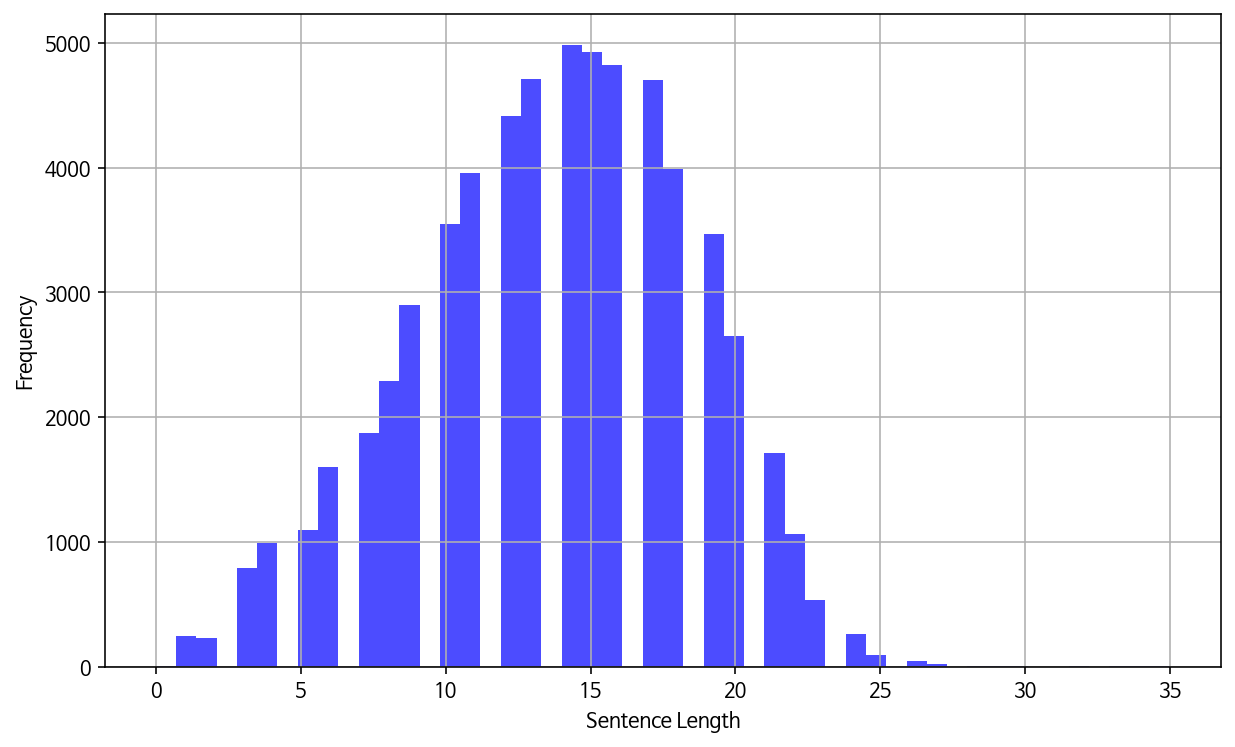

In [9]:
# 데이터 길이 확인
def show_distribution(sentences):
    # Calculate the lengths of all sentences
    sentence_lengths = [len(sent.split()) for sent in sentences]
    
    # Create a histogram
    plt.figure(figsize=(10, 6))
    plt.hist(sentence_lengths, bins=50, color='blue', alpha=0.7)
    
    
    plt.xlabel('Sentence Length')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()
show_distribution(enc_corpus)

### Step 3. 데이터 토큰화
- 토큰화하고 텐서로 변환
- 텐서를 80%의 훈련 데이터와 20%의 검증 데이터로 분리

In [10]:
def ko_tokenize(corpus):
    # 불용어 정의
    #stopwords=['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
    
    tokenizer = Mecab()
    
    tokenized=[]
    for sentence in corpus:
        temp = tokenizer.morphs(sentence) # 토큰화
        #temp = [word for word in temp if not word in stopwords] # 불용어 제거
        tokenized.append(temp) 
    return tokenize(tokenized)

In [11]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=15000, filters='', oov_token="<unk>")
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

In [12]:
#텍스트 데이터 -> 토큰화 진행
enc_corpus_tensor, enc_corpus_tokenizer = ko_tokenize(enc_corpus)
dec_corpus_tensor, dec_corpus_tokenizer = tokenize(dec_corpus)

In [13]:
# 데이터 확인
for idx, word in enumerate(enc_corpus_tokenizer.word_index):
    print(idx, ":", word)

    if idx > 10: break

0 : <unk>
1 : .
2 : 다
3 : 이
4 : 는
5 : 을
6 : 의
7 : 은
8 : 에
9 : 했
10 : 를
11 : 하


In [14]:
#8:2로 비율로 데이터 분리
X_train, X_test = train_test_split(enc_corpus_tensor, test_size=0.2, random_state=3)
Y_train, Y_test = train_test_split(dec_corpus_tensor, test_size=0.2, random_state=3)

### Step 4. 모델 설계
 - 각각 1개의 GRU을 갖는 Encoder-Decoder 구조
 - BahdanauAttention

In [15]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

print("슝~")

슝~


In [16]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units,
                                       return_sequences=True)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)
        
        return out

In [17]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)
        
        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

In [18]:
BATCH_SIZE     = 64
SRC_VOCAB_SIZE = len(enc_corpus_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(dec_corpus_tokenizer.index_word) + 1

units         = 128
embedding_dim = 200

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 40

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (64, 40, 128)
Decoder Output: (64, 38258)
Decoder Hidden State: (64, 128)
Attention: (64, 40, 1)


In [19]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

print("슝~")

슝~


In [20]:
@tf.function
def eval_step(src, tgt, encoder, decoder, dec_tok):
    bsz = src.shape[0]
    loss = 0

    enc_out = encoder(src)

    h_dec = enc_out[:, -1]
    
    dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

    for t in range(1, tgt.shape[1]):
        pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

        loss += loss_function(tgt[:, t], pred)
        dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))
    
    return batch_loss

In [21]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

print("슝~")

슝~


In [22]:
# Training Process

from tqdm import tqdm
import random
EPOCHS = 10

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, X_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(X_train[idx:idx+BATCH_SIZE],
                                Y_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_corpus_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
    
#     test_loss = 0
    
#     idx_list = list(range(0, X_test.shape[0], BATCH_SIZE))
#     random.shuffle(idx_list)
#     t = tqdm(idx_list)

#     for (test_batch, idx) in enumerate(t):
#         test_batch_loss = eval_step(X_test[idx:idx+BATCH_SIZE],
#                                     Y_test[idx:idx+BATCH_SIZE],
#                                     encoder,
#                                     decoder,
#                                     dec_corpus_tokenizer)
    
#         test_loss += test_batch_loss

#         t.set_description_str('Test Epoch %2d' % (epoch + 1))
#         t.set_postfix_str('Test Loss %.4f' % (test_loss.numpy() / (test_batch + 1)))

Epoch 10: 100%|██████████| 775/775 [01:44<00:00,  7.43it/s, Loss 1.9470]


In [23]:
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [24]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((Y_train.shape[-1], X_train.shape[-1]))
    
    sentence = preprocess_sentence(sentence)
    inputs = enc_corpus_tokenizer.texts_to_sequences([sentence.split()])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=X_train.shape[-1],
                                                           padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_corpus_tokenizer.word_index['<start>']], 0)

    for t in range(Y_train.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_corpus_tokenizer.index_word[predicted_id] + ' '

        if dec_corpus_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention

In [31]:
def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence.split())]
    #plot_attention(attention, sentence.split(), result.split(' '))



In [32]:
translate("오바마는 대통령이다.", encoder, decoder)

Input: 오바마는 대통령이다 .
Predicted translation: the <unk> <unk> . <end> 


In [33]:
translate("시민들은 도시 속에 산다.", encoder, decoder)


Input: 시민들은 도시 속에 산다 .
Predicted translation: the <unk> <unk> . <end> 


In [34]:
translate("커피는 필요 없다.", encoder, decoder)

Input: 커피는 필요 없다 .
Predicted translation: we re going to the <unk> . <end> 


In [35]:
translate("일곱 명의 사망자가 발생했다.", encoder, decoder)

Input: 일곱 명의 사망자가 발생했다 .
Predicted translation: the <unk> <unk> . <end> 
